# FYP-DL: Countering Class Imbalance with SMOTE and ADASYN - LogReg

## **S**ystemic **M**inority **O**versampling **T**echnique
- A form of **data augmentation**.
- Draws a straight 'line' or `n-1`-dimensional hyperplane between examples of the minority class in `n`-dimensional feature space.
- Generates a syntethic training example by choosing a point along the hyperplane. 
- Uses a variant of KNN to find the data points between which the line or hyperplane can be drawn.
- Better than undersampling the majority class because it doesn't decrease the size of the dataset/number of majority class examples.
- Better than oversampling the minority class because it doesn't introduce redundant/duplicate training examples for the minority class.
- Also better than oversampling because oversampled examplse don't add any new information to the dataset.
- This works because the new training examples occupy almost the same regions in the minority class's feature space.
- [This paper](https://arxiv.org/abs/1106.1813) says that undersampling the majority class + SMOTE for minority class --> better performance than standalone undersampling or SMOTE.


## ADASYN
- **A**daptive **S**ynthetic **S**ampling
- Generates new training examples for the minority class in regions of the feature space where the density of the minority class is low. 
- Don't generate minority training examples where the feature space is high.

# Installing `imbalanced-learn`
A libary, much like `scikit-learn` with classes and functions for undersampling, oversampling, and working with imbalanced data.

In [2]:
!pip install imbalanced-learn

# Imports

In [4]:
# Standard imports
import numpy as np
import pandas as pd 
import os
from shutil import copy

# For counting the class division before and after resampling
from collections import Counter

# Seeding random number generator
np.random.seed(0)

# For counting number of samples per class
from collections import Counter

# Colab and Drive integration
from google.colab import drive, files

# For plotting 
import matplotlib.pyplot as plt 
%matplotlib inline
from matplotlib import style
style.use('ggplot')
from seaborn import countplot

# Scikit-Learn imports
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_auc_score, \
roc_curve, confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split 

# Scikit-Learn - Logistic Regression
from sklearn.linear_model import LogisticRegression

# Imbalanced Learn
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Functions

In [5]:
def get_classification_result(estimator, X, y_true, classifier_name=None,
                              normalize_conf_mat='all'):
    """Custom function to display classification results"""
    # Predictions will be used several times
    y_pred = estimator.predict(X) 

    # Display the classification report 
    print("CLASSIFICATION REPORT")
    print(classification_report(y_true, y_pred, labels=[0, 1], 
                                target_names=['Regular Consumer', 'Thieves'],))
    
    # Display the confusion matrix
    print("CONFUSION MATRIX")
    if (normalize_conf_mat=='rows'):
      normalize='true'
    elif (normalize_conf_mat=='cols'):
        normalize='pred'
    else:
      normalize=normalize_conf_mat

    # Use built-in function to get confusion matrix for this estimator
    conf_mat_display = plot_confusion_matrix(estimator=estimator, 
                                             X=X, 
                                             y_true=y_true, 
                                             labels=[0, 1],
                                             normalize=normalize, 
                                             display_labels=['Regular Consumers', 'Thieves'], 
                                             cmap=plt.cm.Blues)
    
    # Add a title (with optional classifier name)
    conf_mat_display.ax_.set_title("Confusion Matrix - {}".format(
        classifier_name if classifier_name is not None 
        else 'Test Classifier' ))
    
    # This will render the confusion matrix as an image
    print(conf_mat_display.confusion_matrix);
    plt.grid(False)       # Remove extra lines from confusion matrix

    roc_curve_display = plot_roc_curve(estimator, X, y_true)
    roc_curve_display.ax_.set_title('ROC Curve' +
                                    ('' if classifier_name is None else ' - {}'.format(classifier_name)), 
                                    fontsize=18);

# Mount Google Drive

In [6]:
# Directories
MOUNT_DIR = '/content/drive'
DRIVE_DIR = os.path.join(MOUNT_DIR, 'My Drive')
FYP_DIR = os.path.join(DRIVE_DIR, 'EE 16-17 FYP DL Energy Theft Detection')
DATA_DIR = os.path.join(FYP_DIR, 'Data/full-processing-data')
MODULES_DIR = os.path.join(FYP_DIR, 'Modules')

# Filepaths
DATA_FILE = os.path.join(DATA_DIR, 'outliersRemoved.csv')

In [7]:
drive.mount(MOUNT_DIR, force_remount=True)

Mounted at /content/drive


# Modules

Temporarily loading them from Google Drive because GitHub repo is private.

In [8]:
for fname in os.listdir(MODULES_DIR):
  src = os.path.join(MODULES_DIR, fname)
  dst = os.path.join('./', fname)
  copy(src, dst)

# Reading Data

In [9]:
df = pd.read_csv(DATA_FILE)
df.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,8.56,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.760000,6.150000,6.500000,8.080000,7.97,8.810000,7.370000,11.720000,11.020000,8.180000,7.330000,6.710000,8.520000,6.310000,7.18,8.070000,8.090000,9.530000,5.480000,8.750000,9.300000,7.540000,9.160000,6.740000
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.34,13.483126,13.483126,13.483126,13.483126,12.73,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,10.95,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,17.30,16.95,8.25,22.76,14.07,20.70,6.50,9.99,18.59,16.79,26.82,14.70,16.05,24.10,12.64,10.85,11.770000,13.030000,12.260000,15.660000,13.43,15.030000,14.610000,13.970000,15.070000,14.110000,14.770000,11.720000,11.730000,11.980000,12.81,15.120000,17.260000,14.910000,19.590000,20.790000,17.950000,19.260000,14.460000,11.720000
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,0.88,3.81,6.51,9.19,7.79,7.02,7.25,6.37,6.43,7.89,7.46,7.95,7.59,4.84,6.06,5.6,6.72,7.29,5.6,6.28,...,9.56,9.48,10.60,10.06,10.79,10.91,17.77,10.37,13.51,14.13,17.44,15.96,12.18,18.54,13.44,11.68,9.150000,9.160000,10.190000,10.310000,8.03,10.080000,10.340000,11.240000,15.140000,14.360000,12.390000,10.360000,9.290000,7.910000,14.21,10.220000,8.470000,6.110000,6.100000,6.730000,7.520000,10.890000,9.860000,8.720000


# Extracting Features and Labels

In [10]:
features, labels = df.iloc[:, 2:], df.iloc[:, 1]

In [11]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features, labels, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=labels.values)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  random_state=0, 
                                                  test_size=0.2, 
                                                  stratify=y_train_val.values)

# Feature Scaling

In [13]:
from pipelines import get_pipeline_1D

# Creating pipeline objects
pipeline_1D_std = get_pipeline_1D(scaling_strategy='Standard')
pipeline_1D_minmax = get_pipeline_1D(scaling_strategy='MinMax')

# Fit and then transform the pipelines to the training data first 
# Standard Scaling
X_train_1D_std = pipeline_1D_std.fit_transform(X_train)
X_val_1D_std = pipeline_1D_std.fit_transform(X_val)
X_test_1D_std = pipeline_1D_std.fit_transform(X_test)

# MinMax Scaling
X_train_1D_minmax = pipeline_1D_minmax.fit_transform(X_train)
X_val_1D_minmax = pipeline_1D_minmax.fit_transform(X_val)
X_test_1D_minmax = pipeline_1D_minmax.fit_transform(X_test)

# SMOTE

## Class Distribution Before SMOTE

Counter({0: 24803, 1: 2314})


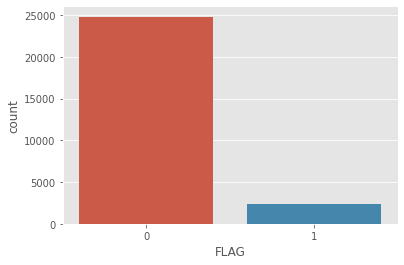

In [22]:
# Prior to any resampling, the data should have a 91.5-8.5 split
counter_original = Counter(y_train)
print(counter_original)
countplot(y_train)

## SMOTE - Standard Scaler Data

In [25]:
# Standard SMOTE that will create synthetic minority samples for 50-50 split
oversample = SMOTE()
X_train_std_smote, y_train_std_smote = oversample.fit_resample(X_train_1D_std, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## SMOTE - MinMax Scaler Data

In [23]:
oversample = SMOTE()
X_train_minmax_smote, y_train_minmax_smote = oversample.fit_resample(X_train_1D_minmax, 
                                                                     y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Class Distribution After SMOTE

In [26]:
# What is the distribution of values after SMOTE?
counter_smote = Counter(y_train_std_smote)
print(counter_smote)

Counter({0: 24803, 1: 24803})


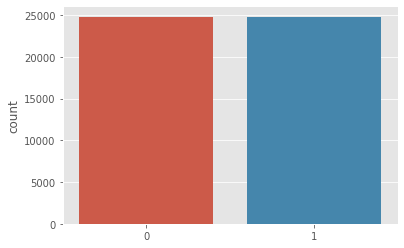

In [27]:
countplot(y_train_std_smote)

As expected, standard `SMOTE` has created new, synthetic training examples for the positive (minority) class so that we now have 31k training examples for both.

# Logistic Regression with SMOTE

## Standard Scaler Model

### Train Model

In [35]:
# Instantiate a logistic regression model
log_reg_smote = LogisticRegression(C=1.0, 
                                   penalty='l2', 
                                   random_state=0, 
                                   max_iter=500, 
                                   verbose=2,
                                   solver='lbfgs')

# Fit to the correct training data
log_reg_smote.fit(X_train_std_smote, y_train_std_smote)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.9s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=2,
                   warm_start=False)

### Validation Set Results - By Row

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.95      0.68      0.79      6202
         Thieves       0.14      0.58      0.23       578

        accuracy                           0.67      6780
       macro avg       0.55      0.63      0.51      6780
    weighted avg       0.88      0.67      0.74      6780

CONFUSION MATRIX
[[0.68187681 0.31812319]
 [0.42214533 0.57785467]]


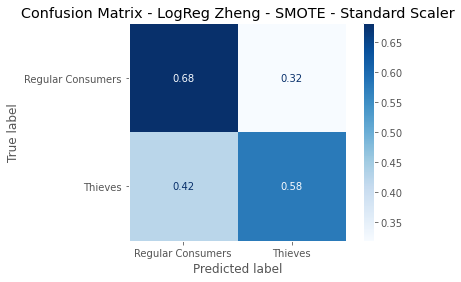

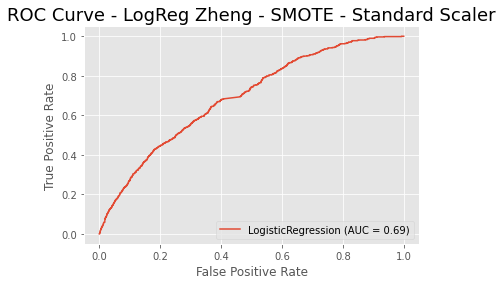

In [36]:
get_classification_result(estimator=log_reg_smote, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - SMOTE - Standard Scaler", 
                          normalize_conf_mat="rows")

### Validation Set Results - By Col

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.95      0.68      0.79      6202
         Thieves       0.14      0.58      0.23       578

        accuracy                           0.67      6780
       macro avg       0.55      0.63      0.51      6780
    weighted avg       0.88      0.67      0.74      6780

CONFUSION MATRIX
[[0.94545048 0.85522323]
 [0.05454952 0.14477677]]


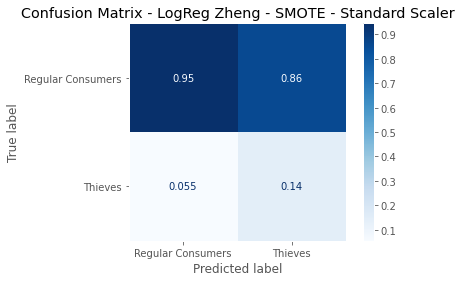

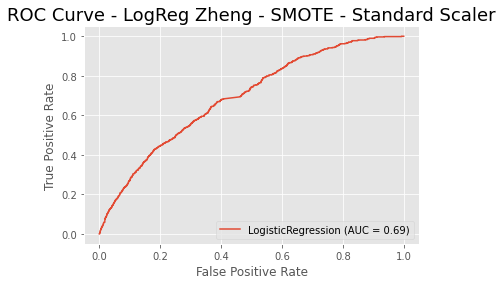

In [37]:
get_classification_result(estimator=log_reg_smote, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - SMOTE - Standard Scaler", 
                          normalize_conf_mat="cols")

### Validation Set Results - By All

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.95      0.68      0.79      6202
         Thieves       0.14      0.58      0.23       578

        accuracy                           0.67      6780
       macro avg       0.55      0.63      0.51      6780
    weighted avg       0.88      0.67      0.74      6780

CONFUSION MATRIX
[[0.62374631 0.29100295]
 [0.0359882  0.04926254]]


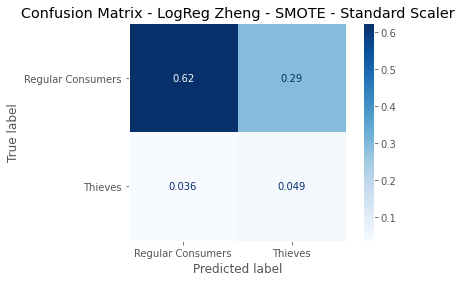

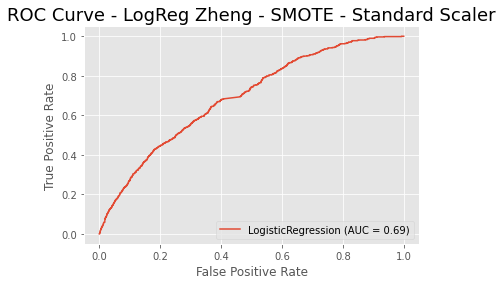

In [38]:
get_classification_result(estimator=log_reg_smote, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - SMOTE - Standard Scaler", 
                          normalize_conf_mat="all")

## MinMax Model

### Train Model

In [40]:
# Instantiate a logistic regression model
log_reg_smote = LogisticRegression(C=1.0, 
                                   penalty='l2', 
                                   random_state=0, 
                                   max_iter=500, 
                                   verbose=2,
                                   solver='lbfgs')

# Fit to the minmax data
log_reg_smote.fit(X_train_minmax_smote, y_train_minmax_smote)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.1s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=2,
                   warm_start=False)

### Val Results - By Row

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.95      0.72      0.82      6202
         Thieves       0.16      0.55      0.24       578

        accuracy                           0.71      6780
       macro avg       0.55      0.64      0.53      6780
    weighted avg       0.88      0.71      0.77      6780

CONFUSION MATRIX
[[0.7247662  0.2752338 ]
 [0.44982699 0.55017301]]


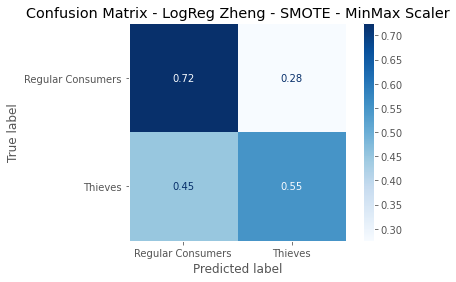

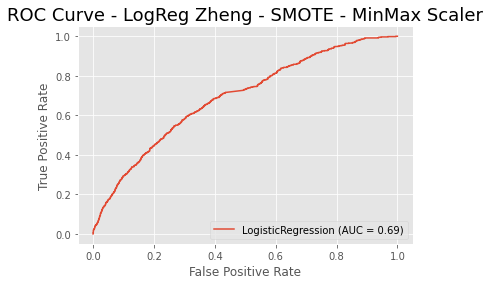

In [41]:
get_classification_result(estimator=log_reg_smote, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - SMOTE - MinMax Scaler", 
                          normalize_conf_mat="rows")

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.95      0.72      0.82      6202
         Thieves       0.16      0.55      0.24       578

        accuracy                           0.71      6780
       macro avg       0.55      0.64      0.53      6780
    weighted avg       0.88      0.71      0.77      6780

CONFUSION MATRIX
[[0.94532072 0.84296296]
 [0.05467928 0.15703704]]


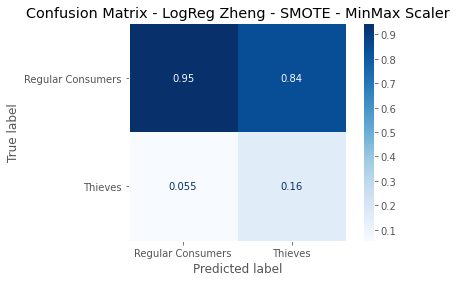

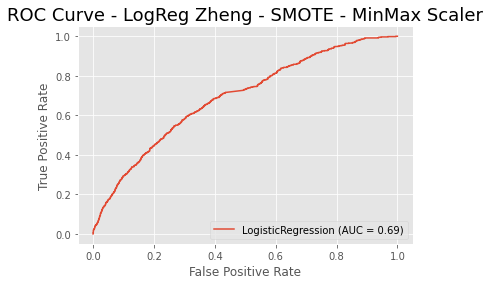

In [42]:
 get_classification_result(estimator=log_reg_smote, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - SMOTE - MinMax Scaler", 
                          normalize_conf_mat="cols")

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.95      0.72      0.82      6202
         Thieves       0.16      0.55      0.24       578

        accuracy                           0.71      6780
       macro avg       0.55      0.64      0.53      6780
    weighted avg       0.88      0.71      0.77      6780

CONFUSION MATRIX
[[0.66297935 0.25176991]
 [0.03834808 0.04690265]]


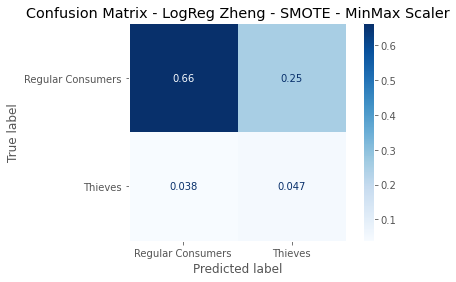

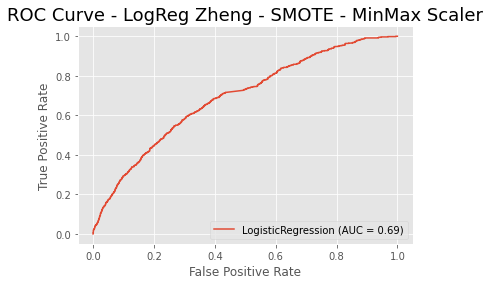

In [43]:
get_classification_result(estimator=log_reg_smote, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - SMOTE - MinMax Scaler", 
                          normalize_conf_mat="all")

# SMOTE and Majority Undersampling

According to the original research paper on SMOTE, this technique performs better when the majority class is undersampled in conjunction with smote.

In [71]:
# Oversample the minority class to have 30% as many samples as original majority class
oversampler = SMOTE(sampling_strategy=0.3)

# Undersample the minority class to have as many samples as minority class
undersampler = RandomUnderSampler(sampling_strategy=0.7)

# Create a pipeline with the two sampling steps
sampling_pipeline = Pipeline([('over', oversampler), ('under', undersampler)])

## Class Distribution Before Resampling

Counter({0: 24803, 1: 2314})


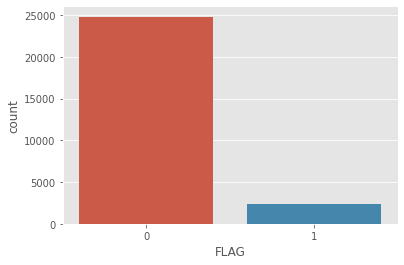

In [72]:
counter = Counter(y_train) 
print(counter)
countplot(y_train)

## Resampling - Standard Scaler Data

In [73]:
X_train_std_resampled, y_train_std_resampled = sampling_pipeline.fit_resample(
    X_train_1D_std, y_train
)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 10628, 1: 7440})


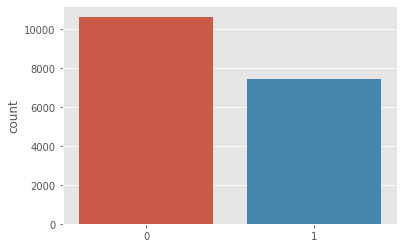

In [74]:
print(Counter(y_train_std_resampled))
countplot(y_train_std_resampled)

## Resampling - MinMax Scaler Data

In [75]:
X_train_minmax_resampled, y_train_minmax_resampled = sampling_pipeline.fit_resample(
    X_train_1D_minmax, y_train
)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 10628, 1: 7440})


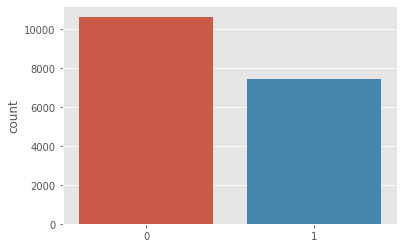

In [76]:
print(Counter(y_train_minmax_resampled))
countplot(y_train_minmax_resampled)

# Logistic Regression with SMOTE + Majority Oversampling

## Standard Scaler Model

In [77]:
# Instantiate a logistic regression model
log_reg_smote = LogisticRegression(C=1.0, 
                                   penalty='l2', 
                                   random_state=0, 
                                   max_iter=500, 
                                   verbose=2,
                                   solver='liblinear')

# Fit to the correct training data
log_reg_smote.fit(X_train_std_resampled, y_train_std_resampled)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=2,
                   warm_start=False)

### By Row

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.94      0.76      0.84      6202
         Thieves       0.16      0.50      0.24       578

        accuracy                           0.73      6780
       macro avg       0.55      0.63      0.54      6780
    weighted avg       0.87      0.73      0.79      6780

CONFUSION MATRIX
[[0.75572396 0.24427604]
 [0.50346021 0.49653979]]


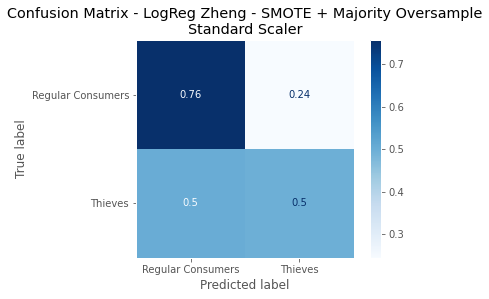

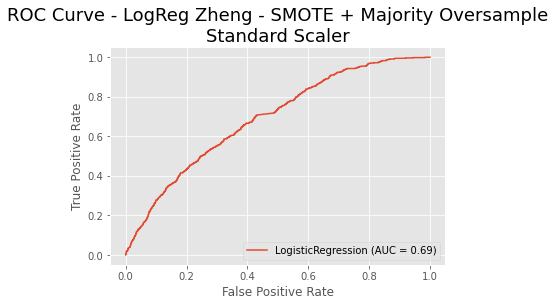

In [78]:
get_classification_result(estimator=log_reg_smote, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - SMOTE + Majority Oversample\nStandard Scaler", 
                          normalize_conf_mat="rows")

### By Col

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.94      0.76      0.84      6202
         Thieves       0.16      0.50      0.24       578

        accuracy                           0.73      6780
       macro avg       0.55      0.63      0.54      6780
    weighted avg       0.87      0.73      0.79      6780

CONFUSION MATRIX
[[0.94154279 0.84073252]
 [0.05845721 0.15926748]]


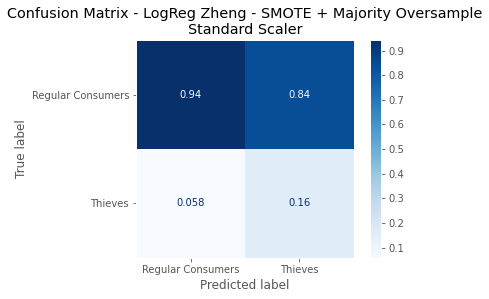

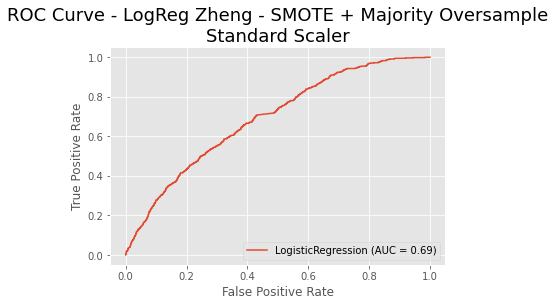

In [79]:
get_classification_result(estimator=log_reg_smote, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - SMOTE + Majority Oversample\nStandard Scaler", 
                          normalize_conf_mat="cols")

### By All

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.94      0.76      0.84      6202
         Thieves       0.16      0.50      0.24       578

        accuracy                           0.73      6780
       macro avg       0.55      0.63      0.54      6780
    weighted avg       0.87      0.73      0.79      6780

CONFUSION MATRIX
[[0.69129794 0.22345133]
 [0.04292035 0.04233038]]


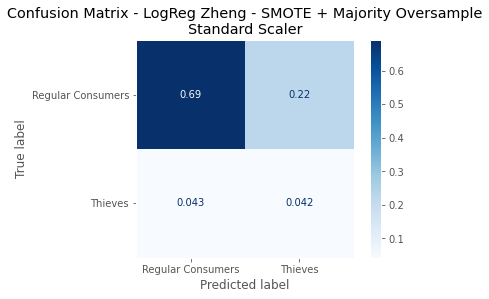

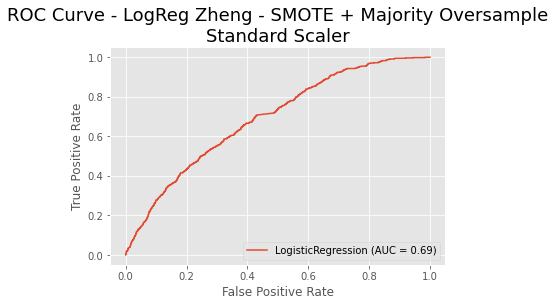

In [80]:
get_classification_result(estimator=log_reg_smote, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - SMOTE + Majority Oversample\nStandard Scaler", 
                          normalize_conf_mat="all")

## MinMax Model

In [81]:
# Instantiate a logistic regression model
log_reg_smote = LogisticRegression(C=1.0, 
                                   penalty='l2', 
                                   random_state=0, 
                                   max_iter=500, 
                                   verbose=2,
                                   solver='liblinear')

# Fit to the correct training data
log_reg_smote.fit(X_train_minmax_resampled, y_train_minmax_resampled)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=2,
                   warm_start=False)

### By Row

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.94      0.78      0.85      6202
         Thieves       0.17      0.47      0.25       578

        accuracy                           0.76      6780
       macro avg       0.55      0.63      0.55      6780
    weighted avg       0.87      0.76      0.80      6780

CONFUSION MATRIX
[[0.78329571 0.21670429]
 [0.53114187 0.46885813]]


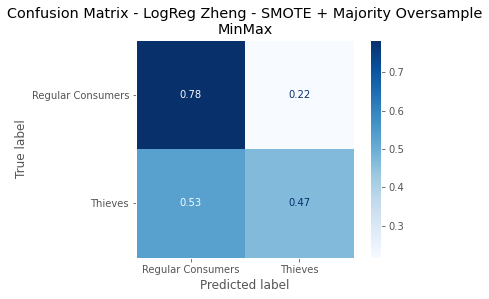

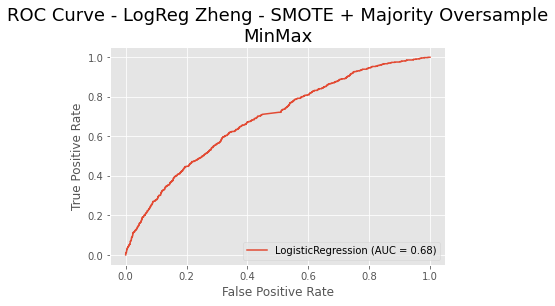

In [82]:
get_classification_result(estimator=log_reg_smote, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - SMOTE + Majority Oversample\nMinMax", 
                          normalize_conf_mat="rows")

### By Col

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.94      0.78      0.85      6202
         Thieves       0.17      0.47      0.25       578

        accuracy                           0.76      6780
       macro avg       0.55      0.63      0.55      6780
    weighted avg       0.87      0.76      0.80      6780

CONFUSION MATRIX
[[0.94056147 0.83219814]
 [0.05943853 0.16780186]]


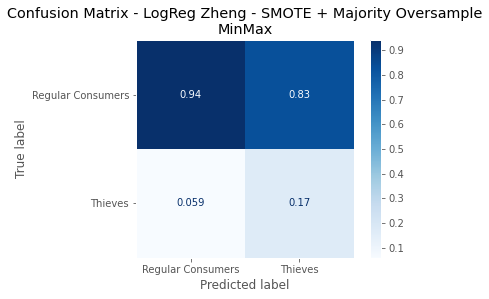

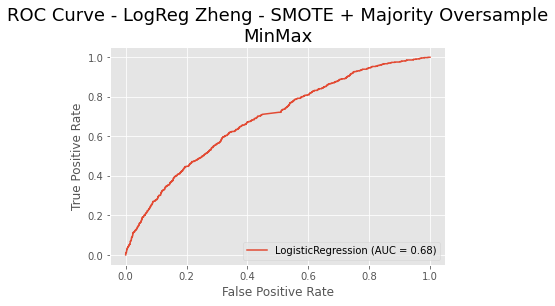

In [83]:
get_classification_result(estimator=log_reg_smote, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - SMOTE + Majority Oversample\nMinMax", 
                          normalize_conf_mat="cols")

### By All

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.94      0.78      0.85      6202
         Thieves       0.17      0.47      0.25       578

        accuracy                           0.76      6780
       macro avg       0.55      0.63      0.55      6780
    weighted avg       0.87      0.76      0.80      6780

CONFUSION MATRIX
[[0.71651917 0.19823009]
 [0.04528024 0.0399705 ]]


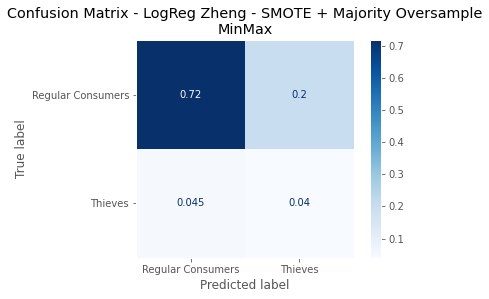

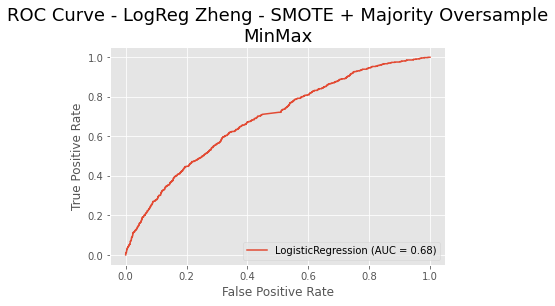

In [84]:
get_classification_result(estimator=log_reg_smote, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - SMOTE + Majority Oversample\nMinMax", 
                          normalize_conf_mat="all")

# Borderline SMOTE

All variants of SMOTE tested so far will generate synthetic samples by drawing samples from the hyperplane between neighbouring examples of the minority class, regardless of how likely these examples are to be misclassified.

Intuitively, it makes more sense to generate synthetic examples only for those training examples or regions of the feature space where classification is difficult.

Borderline SMOTE will generate synthetic samples only for those training examples which are misclassified by a KNN classifier. 

## Resampling - Standard Scaler Data

In [70]:
borderline_smote = BorderlineSMOTE() 
X_train_std_resampled, y_train_std_resampled = borderline_smote.fit_resample(
    X_train_1D_std, y_train
)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 10628, 1: 7440})


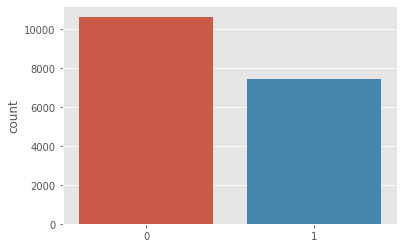

In [85]:
print(Counter(y_train_std_resampled))
countplot(y_train_std_resampled)

## Resampling - MinMax Scaler Data

In [86]:
borderline_smote = BorderlineSMOTE() 
X_train_minmax_resampled, y_train_minmax_resampled = borderline_smote.fit_resample(
    X_train_1D_minmax, y_train
)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 24803, 1: 24803})


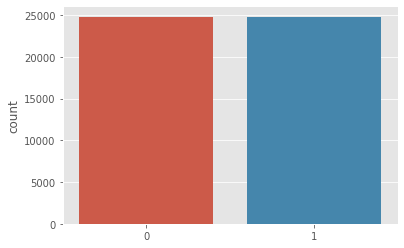

In [87]:
print(Counter(y_train_minmax_resampled))
countplot(y_train_minmax_resampled)

# Logistic Regression - Borderline SMOTE

## Standard Scaler Model

In [88]:
# Instantiate a logistic regression model
log_reg_smote = LogisticRegression(C=1.0, 
                                   penalty='l2', 
                                   random_state=0, 
                                   max_iter=500, 
                                   verbose=2,
                                   solver='liblinear')

# Fit to the correct training data
log_reg_smote.fit(X_train_std_resampled, y_train_std_resampled)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=2,
                   warm_start=False)

### By Row

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.94      0.76      0.84      6202
         Thieves       0.16      0.50      0.24       578

        accuracy                           0.73      6780
       macro avg       0.55      0.63      0.54      6780
    weighted avg       0.87      0.73      0.79      6780

CONFUSION MATRIX
[[0.75572396 0.24427604]
 [0.50346021 0.49653979]]


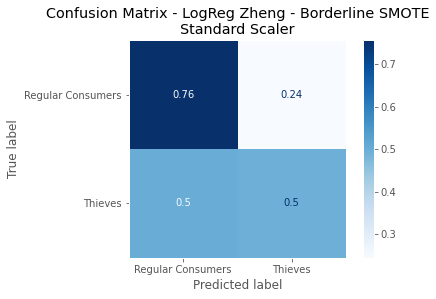

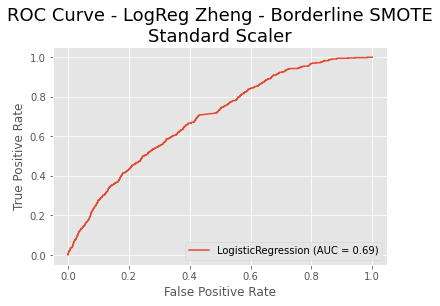

In [90]:
get_classification_result(estimator=log_reg_smote, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - Borderline SMOTE\nStandard Scaler", 
                          normalize_conf_mat="rows")

### By Col

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.94      0.76      0.84      6202
         Thieves       0.16      0.50      0.24       578

        accuracy                           0.73      6780
       macro avg       0.55      0.63      0.54      6780
    weighted avg       0.87      0.73      0.79      6780

CONFUSION MATRIX
[[0.94154279 0.84073252]
 [0.05845721 0.15926748]]


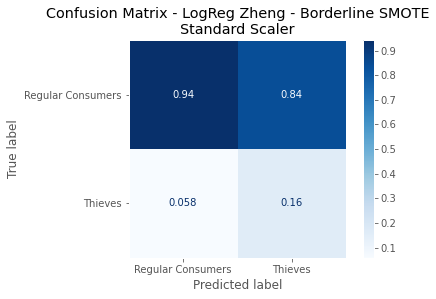

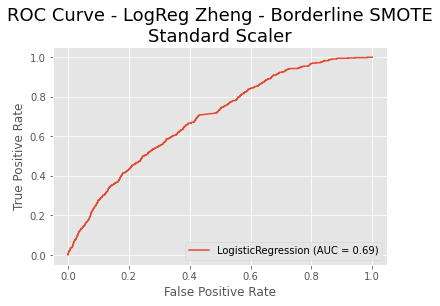

In [91]:
get_classification_result(estimator=log_reg_smote, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - Borderline SMOTE\nStandard Scaler", 
                          normalize_conf_mat="cols")

### By All

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.94      0.76      0.84      6202
         Thieves       0.16      0.50      0.24       578

        accuracy                           0.73      6780
       macro avg       0.55      0.63      0.54      6780
    weighted avg       0.87      0.73      0.79      6780

CONFUSION MATRIX
[[0.69129794 0.22345133]
 [0.04292035 0.04233038]]


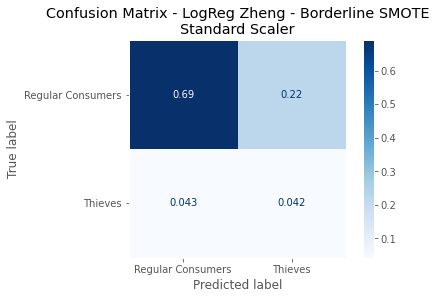

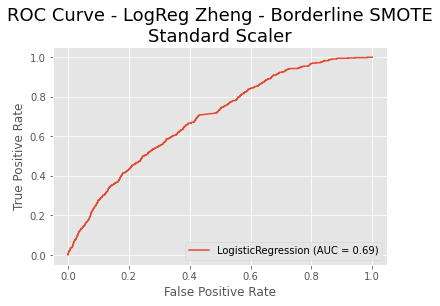

In [89]:
get_classification_result(estimator=log_reg_smote, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - Borderline SMOTE\nStandard Scaler", 
                          normalize_conf_mat="all")

## MinMax Model

In [92]:
# Instantiate a logistic regression model
log_reg_smote = LogisticRegression(C=1.0, 
                                   penalty='l2', 
                                   random_state=0, 
                                   max_iter=500, 
                                   verbose=2,
                                   solver='liblinear')

# Fit to the correct training data
log_reg_smote.fit(X_train_minmax_resampled, y_train_minmax_resampled)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=2,
                   warm_start=False)

### By Row

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.94      0.74      0.83      6202
         Thieves       0.15      0.51      0.24       578

        accuracy                           0.72      6780
       macro avg       0.55      0.62      0.53      6780
    weighted avg       0.87      0.72      0.78      6780

CONFUSION MATRIX
[[0.7428249  0.2571751 ]
 [0.49480969 0.50519031]]


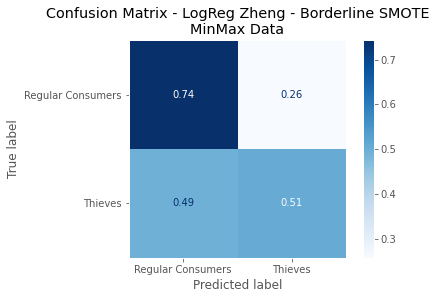

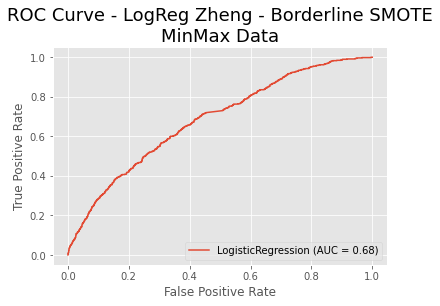

In [94]:
get_classification_result(estimator=log_reg_smote, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - Borderline SMOTE\nMinMax Data", 
                          normalize_conf_mat="rows")

### By Col

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.94      0.74      0.83      6202
         Thieves       0.15      0.51      0.24       578

        accuracy                           0.72      6780
       macro avg       0.55      0.62      0.53      6780
    weighted avg       0.87      0.72      0.78      6780

CONFUSION MATRIX
[[0.94154915 0.84525702]
 [0.05845085 0.15474298]]


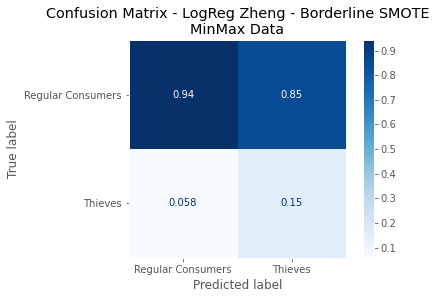

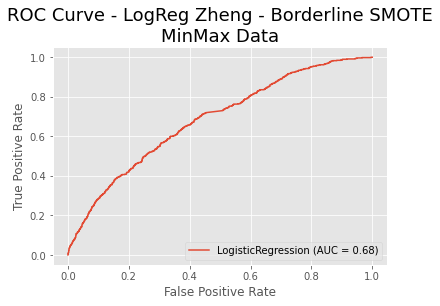

In [95]:
get_classification_result(estimator=log_reg_smote, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - Borderline SMOTE\nMinMax Data", 
                          normalize_conf_mat="cols")

### By All

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.94      0.74      0.83      6202
         Thieves       0.15      0.51      0.24       578

        accuracy                           0.72      6780
       macro avg       0.55      0.62      0.53      6780
    weighted avg       0.87      0.72      0.78      6780

CONFUSION MATRIX
[[0.67949853 0.23525074]
 [0.04218289 0.04306785]]


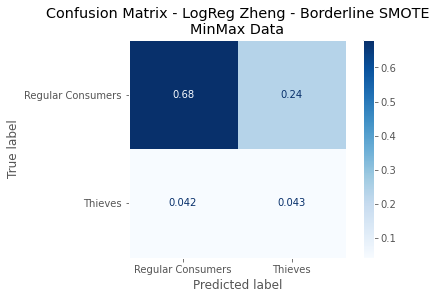

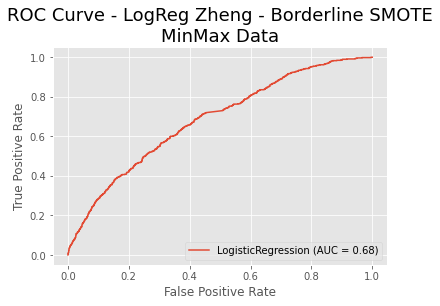

In [93]:
get_classification_result(estimator=log_reg_smote, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - Borderline SMOTE\nMinMax Data", 
                          normalize_conf_mat="all")

# ADASYN

## Resampling - Standard Scaler Data

In [14]:
adasyn_std = ADASYN() 
X_train_std_resampled, y_train_std_resampled = adasyn_std.fit_resample(
    X_train_1D_std, y_train
)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Resampling - MinMax Scaler Data

In [15]:
adasyn_minmax = ADASYN() 
X_train_minmax_resampled, y_train_minmax_resampled = adasyn_minmax.fit_resample(
    X_train_1D_minmax, y_train
)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# Logistic Regression - ADASYN

## Standard Scaler Model

In [23]:
# Instantiate a logistic regression model
log_reg_adasyn = LogisticRegression(C=1.0, 
                                   penalty='l2', 
                                   random_state=0, 
                                   max_iter=500, 
                                   verbose=2,
                                   solver='liblinear')

# Fit to the correct training data
log_reg_adasyn.fit(X_train_std_resampled, y_train_std_resampled)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=2,
                   warm_start=False)

### By Row

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.94      0.68      0.79      6202
         Thieves       0.14      0.57      0.23       578

        accuracy                           0.67      6780
       macro avg       0.54      0.63      0.51      6780
    weighted avg       0.88      0.67      0.74      6780

CONFUSION MATRIX
[[0.6772009  0.3227991 ]
 [0.42560554 0.57439446]]


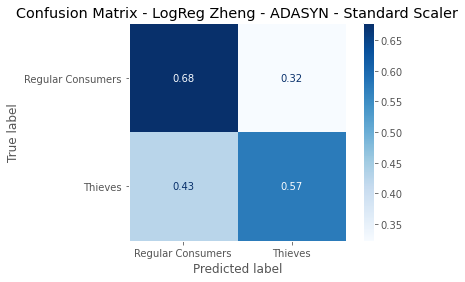

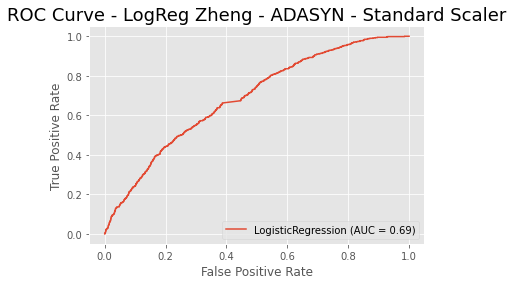

In [24]:
get_classification_result(estimator=log_reg_adasyn, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - ADASYN - Standard Scaler", 
                          normalize_conf_mat="rows")

### By Col

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.94      0.68      0.79      6202
         Thieves       0.14      0.57      0.23       578

        accuracy                           0.67      6780
       macro avg       0.54      0.63      0.51      6780
    weighted avg       0.88      0.67      0.74      6780

CONFUSION MATRIX
[[0.94466937 0.85775493]
 [0.05533063 0.14224507]]


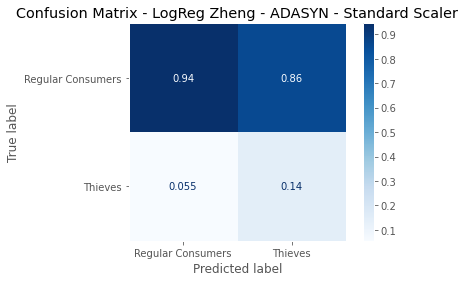

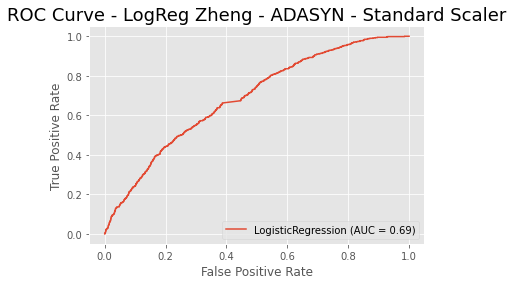

In [25]:
get_classification_result(estimator=log_reg_adasyn, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - ADASYN - Standard Scaler", 
                          normalize_conf_mat="cols")

### By All

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.94      0.68      0.79      6202
         Thieves       0.14      0.57      0.23       578

        accuracy                           0.67      6780
       macro avg       0.54      0.63      0.51      6780
    weighted avg       0.88      0.67      0.74      6780

CONFUSION MATRIX
[[0.61946903 0.29528024]
 [0.03628319 0.04896755]]


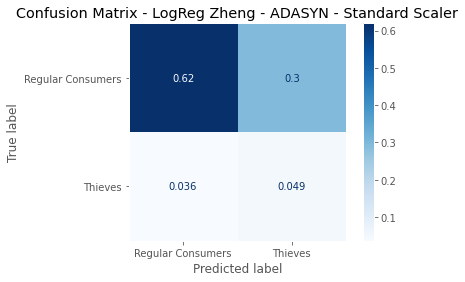

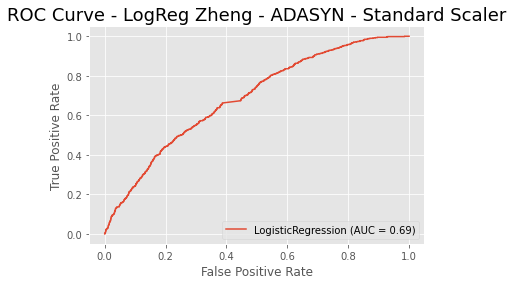

In [26]:
get_classification_result(estimator=log_reg_adasyn, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - ADASYN - Standard Scaler", 
                          normalize_conf_mat="all")

## MinMax Model

In [27]:
# Instantiate a logistic regression model
log_reg_adasyn = LogisticRegression(C=1.0, 
                                   penalty='l2', 
                                   random_state=0, 
                                   max_iter=500, 
                                   verbose=2,
                                   solver='liblinear')

# Fit to the correct training data
log_reg_adasyn.fit(X_train_minmax_resampled, y_train_minmax_resampled)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=2,
                   warm_start=False)

### By Row

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.94      0.72      0.82      6202
         Thieves       0.15      0.55      0.24       578

        accuracy                           0.70      6780
       macro avg       0.55      0.63      0.53      6780
    weighted avg       0.88      0.70      0.77      6780

CONFUSION MATRIX
[[0.71847791 0.28152209]
 [0.45155709 0.54844291]]


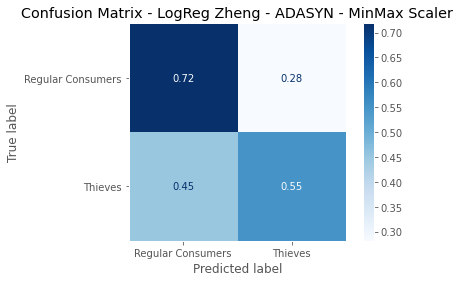

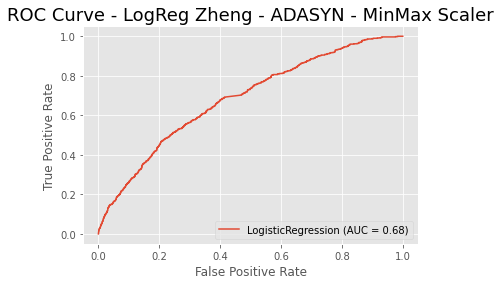

In [28]:
get_classification_result(estimator=log_reg_adasyn, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - ADASYN - MinMax Scaler", 
                          normalize_conf_mat="rows")

### By Col

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.94      0.72      0.82      6202
         Thieves       0.15      0.55      0.24       578

        accuracy                           0.70      6780
       macro avg       0.55      0.63      0.53      6780
    weighted avg       0.88      0.70      0.77      6780

CONFUSION MATRIX
[[0.94466822 0.84634028]
 [0.05533178 0.15365972]]


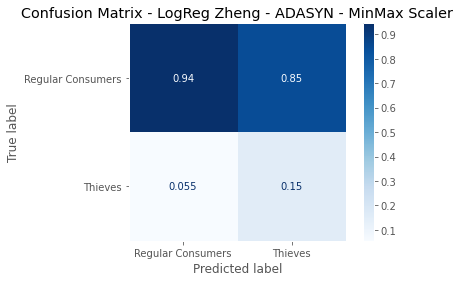

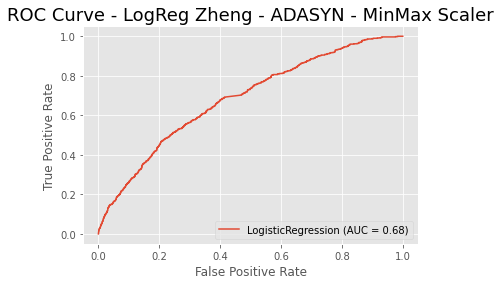

In [29]:
get_classification_result(estimator=log_reg_adasyn, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - ADASYN - MinMax Scaler", 
                          normalize_conf_mat="cols")

### By All

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.94      0.72      0.82      6202
         Thieves       0.15      0.55      0.24       578

        accuracy                           0.70      6780
       macro avg       0.55      0.63      0.53      6780
    weighted avg       0.88      0.70      0.77      6780

CONFUSION MATRIX
[[0.65722714 0.25752212]
 [0.03849558 0.04675516]]


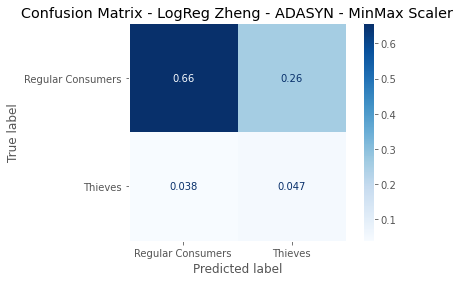

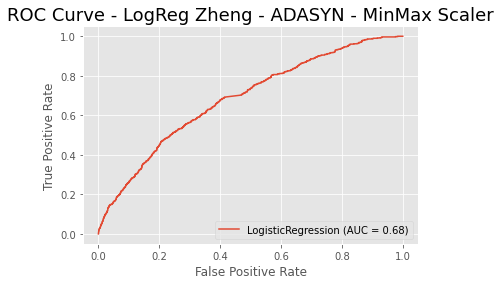

In [30]:
get_classification_result(estimator=log_reg_adasyn, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="LogReg Zheng - ADASYN - MinMax Scaler", 
                          normalize_conf_mat="all")